In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from pyueye import ueye
import ctypes
import time

In [2]:
def success(retval, expected=[]):
    # evaluates whether a pyueye function completed successfully
    # attempts to display errors if detected (though python seems to catch most of them anyway)
    # if retval is expected to be a value (such as a "get" command), enter acceptable values in expected
    # if retval is in expected, retval is returned
    if retval == ueye.IS_SUCCESS:
        return True

    if any([retval == value for value in expected]):
        return retval
        
    global camera
    LastErrVal = ueye.int()
    LastErrMsg = ueye.char_p()
    LastErrMsg.value = 'None'.encode('utf-8')
    ret = ueye.is_GetError(camera, LastErrVal, LastErrMsg)
    if ret == ueye.IS_SUCCESS:
        raise RuntimeError(f"{LastErrVal.value}, {LastErrMsg.value.decode('utf-8')}")
    else:
        raise RuntimeError(f"Function returned {retval.value}, message could not be retreived.")

In [3]:
camnum = ueye.INT()
success(ueye.is_GetNumberOfCameras(camnum))
assert camnum.value > 0, "No cameras detected"

camlist = ueye.UEYE_CAMERA_LIST()
camlist.dwCount.value = camnum.value
success(ueye.is_GetCameraList(camlist))

# Initialize the first camera connected
camera = ueye.HIDS(0)
ret = success(ueye.is_InitCamera(camera, None))
if ret:
    print("Initialized camera", camera.value)
else:
    print("Failed to initialize camera")

Initialized camera 1


In [11]:
caminfo = ueye.CAMINFO()
success(ueye.is_GetCameraInfo(camera, caminfo))

# Get sensor width and height
sensorinfo = ueye.SENSORINFO()
success(ueye.is_GetSensorInfo(camera, sensorinfo))
width = sensorinfo.nMaxWidth
height = sensorinfo.nMaxHeight
print(f"Camera model: {sensorinfo.strSensorName.decode('utf-8')}")
print(f"Sensor dimensions (WxH): {width.value} x {height.value}")

Camera model: UI306xCP-M
Sensor dimensions (WxH): 1936 x 1216


In [12]:
# Get valid pixel clocks and set to minimum
num_clocks = ueye.UINT()
success(ueye.is_PixelClock(camera, ueye.IS_PIXELCLOCK_CMD_GET_NUMBER, num_clocks, ueye.sizeof(num_clocks)))
ClockList = (ueye.UINT * num_clocks.value)() 
success(ueye.is_PixelClock(camera, ueye.IS_PIXELCLOCK_CMD_GET_LIST, ClockList, ueye.sizeof(ClockList)))

minclock = min(ClockList)
success(ueye.is_PixelClock(camera, ueye.IS_PIXELCLOCK_CMD_SET, minclock, ueye.sizeof(minclock)))
print(f"Set pixel clock to minimum value of {minclock.value} MHz.")

Set pixel clock to minimum value of 30 MHz.


In [59]:
# Disable auto shutter and auto frame rate
val = ueye.double(0)
success(ueye.is_SetAutoParameter(camera, ueye.IS_SET_ENABLE_AUTO_SHUTTER, val, val))
success(ueye.is_SetAutoParameter(camera, ueye.IS_SET_ENABLE_AUTO_FRAMERATE, val, val))

# UI306x supports bit depths up to 12, but 16 bits per pixel must be allocated
success(ueye.is_SetColorMode(camera, ueye.IS_CM_SENSOR_RAW12))
bitsperpixel = ueye.INT(16)

# Record image data into memory
success(ueye.is_SetDisplayMode(camera, ueye.IS_SET_DM_DIB))

# enable long exposures and set exposure time (max 30s)
longenabled = ueye.INT(1)
exp = ueye.double(3e4) # in milliseconds
success(ueye.is_Exposure(camera, ueye.IS_EXPOSURE_CMD_SET_LONG_EXPOSURE_ENABLE, longenabled, ueye.sizeof(longenabled)))
success(ueye.is_Exposure(camera, ueye.IS_EXPOSURE_CMD_SET_EXPOSURE, exp, ueye.sizeof(exp)))
success(ueye.is_Exposure(camera, ueye.IS_EXPOSURE_CMD_GET_EXPOSURE, exp, ueye.sizeof(exp)))
print(f"Exposure time set to {(exp.value/1e3):.2f} seconds.")

Exposure time set to 30.00 seconds.


In [60]:
# Get framerate to confirm it is correct
fps = ueye.IS_GET_FRAMERATE
newfps = ueye.double()
success(ueye.is_SetFrameRate(camera, fps, newfps))
assert -1e-2 < (newfps.value * exp.value / 1e3) - 1 < 1e-2, "Frame rate and exposure time do not match"

In [15]:
# Allocate memory and make it the active memory
memaddr = ueye.c_mem_p()
memID = ueye.INT()
success(ueye.is_AllocImageMem(camera, width, height, bitsperpixel, memaddr, memID))
success(ueye.is_SetImageMem(camera, memaddr, memID));

In [61]:
# Initialize wait-for-exposure event
initwait = ueye.IS_INIT_EVENT()
initwait.nEvent = ueye.IS_SET_EVENT_FRAME
initwait.bManualReset = False
initwait.bInitialState = False
success(ueye.is_Event(camera, ueye.IS_EVENT_CMD_INIT, initwait, ueye.sizeof(initwait)))

# Set to require software trigger so that camera does not free-run
success(ueye.is_SetExternalTrigger(camera, ueye.IS_SET_TRIGGER_SOFTWARE));

In [71]:
# Enable wait-for-exposure event
imgavail = ueye.UINT(ueye.IS_SET_EVENT_FRAME)
success(ueye.is_Event(camera, ueye.IS_EVENT_CMD_ENABLE, imgavail, ueye.sizeof(imgavail)))

# Start exposure
start = time.time()
success(ueye.is_FreezeVideo(camera, ueye.IS_DONT_WAIT))

# Wait for exposure to be in memory (and post-processed)
waitforimg = ueye.IS_WAIT_EVENT()
waitforimg.nEvent = imgavail
waitforimg.nTimeoutMilliseconds = ueye.UINT(35000)
success(ueye.is_Event(camera, ueye.IS_EVENT_CMD_WAIT, waitforimg, ueye.sizeof(waitforimg)))

end = time.time()
elapsed = end - start
print(f"Image taken in {elapsed:.2f} seconds.")

# Disable event
success(ueye.is_Event(camera, ueye.IS_EVENT_CMD_DISABLE, imgavail, ueye.sizeof(imgavail)));

Image taken in 30.13 seconds.


In [72]:
# convert to numpy array
total_bytes = width * height * ((bitsperpixel + 7) // 8)
raw_data = ctypes.string_at(memaddr, total_bytes)
arr = np.frombuffer(raw_data, dtype=np.int16)
img = arr.reshape((height.value, width.value))

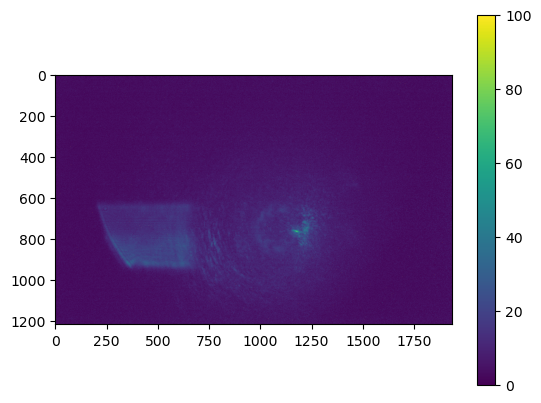

In [75]:
# plot image
plt.imshow(img-dark, vmin=0, vmax=100)
plt.colorbar()

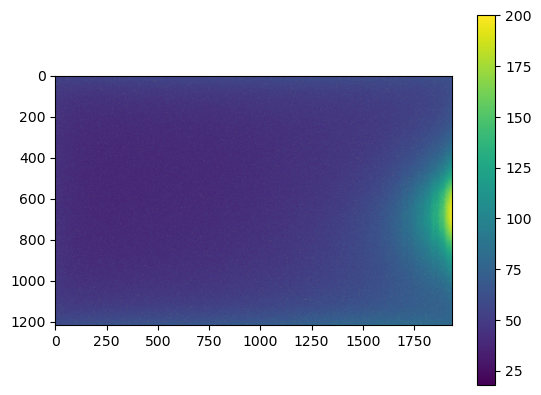

In [67]:
# plot image
dark = img
plt.imshow(dark, vmax=200)
plt.colorbar()

In [76]:
# create header-data object and write to a fits file
hdu = fits.PrimaryHDU(data=img-dark)
hdul = fits.HDUList([hdu])
# hdul.writeto('./Images/30s_LED_on-minus-off_5ax-stage_uncleaved.fits', overwrite=False)

In [77]:
success(ueye.is_ExitCamera(1))

True